# descriptive stats 

- sequence count + metadata (countries/regions/...) 
- sampling over time 
- similarity to original dataset


load libraries

In [141]:
library(tidyverse)
library(lubridate)
library(ggplot2)
library(RColorBrewer)
library(viridis)
library(scales)
library(ggbreak) 
library(patchwork)


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [389]:
metadata_path <- '/Users/nashwa/Desktop/git/hmpxv_dynamics/out/meta.tsv'
og_path <- '/Users/nashwa/Desktop/git/hmpxv_dynamics/monkeypox-build/236masked/hmpxv1/good_metadata.tsv'

meta <- read_tsv(metadata_path)
og <- read_tsv(og_path)

Rows: 226 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (23): strain, accession, genbank_accession_rev, strain_original, date, ...
dbl   (4): coverage, missing_data, divergence, nonACGTN
lgl   (2): reverse, is_reverse_complement
date  (1): date_submitted

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2789 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (23): strain, accession, genbank_accession_rev, strain_original, date, ...
dbl   (4): coverage, missing_data, divergence, nonACGTN
lgl   (2): reverse, is_reverse_complement
date  (1): date_submitted

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the

In [493]:
my_theme <- function() {
    theme_classic() +
    theme( 
        plot.title = element_text(color="black", size=12, face="bold"),
        axis.title.x = element_text(color="black", size=20, face="bold", vjust=2),
        axis.title.y = element_text(color="black", size=20, face="bold", vjust=2),
      #  axis.text.x = element_text(size= 10, vjust=0.5),
      #  axis.text.y = element_text(size = 10),
        axis.text=element_text(size=24),
        )
}

options(repr.plot.width=14, repr.plot.height=8)

In [449]:
lin_b <- c('B.1',
 'B.1.1',
 'B.1.10',
 'B.1.11',
 'B.1.12',
 'B.1.13',
 'B.1.14',
 'B.1.2',
 'B.1.3',
 'B.1.4',
 'B.1.5',
 'B.1.6',
 'B.1.7',
 'B.1.8',
 'B.1.9')

og <- og %>% filter(lineage %in% lin_b) %>%
    select('strain','date','region','country','lineage') %>%
    mutate(tmp = str_replace(country, 'UnitedKingdom', 'United Kingdom')) %>%
    filter(!grepl('-XX-XX', date)) %>% 
    mutate(tmp = str_replace(date, '-XX', '-01')) %>%
    mutate(date = ymd(tmp)) %>% 
    mutate(decimal = decimal_date(date)) %>% 
    mutate(month=month(date)) %>% 
    select(-tmp) 


### plot counts over time 

In [554]:
meta_counts <- meta %>% group_by(date, month) %>% count()
og_counts <- og %>% group_by(date,month) %>% count()

In [607]:
og_month <- og %>% group_by(month) %>% summarise(counts=n())
meta_month <- meta %>% group_by(month) %>% summarise(counts=n())

Warning message in geom_histogram(position = "stack", stat = "identity", bins = 8, :
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


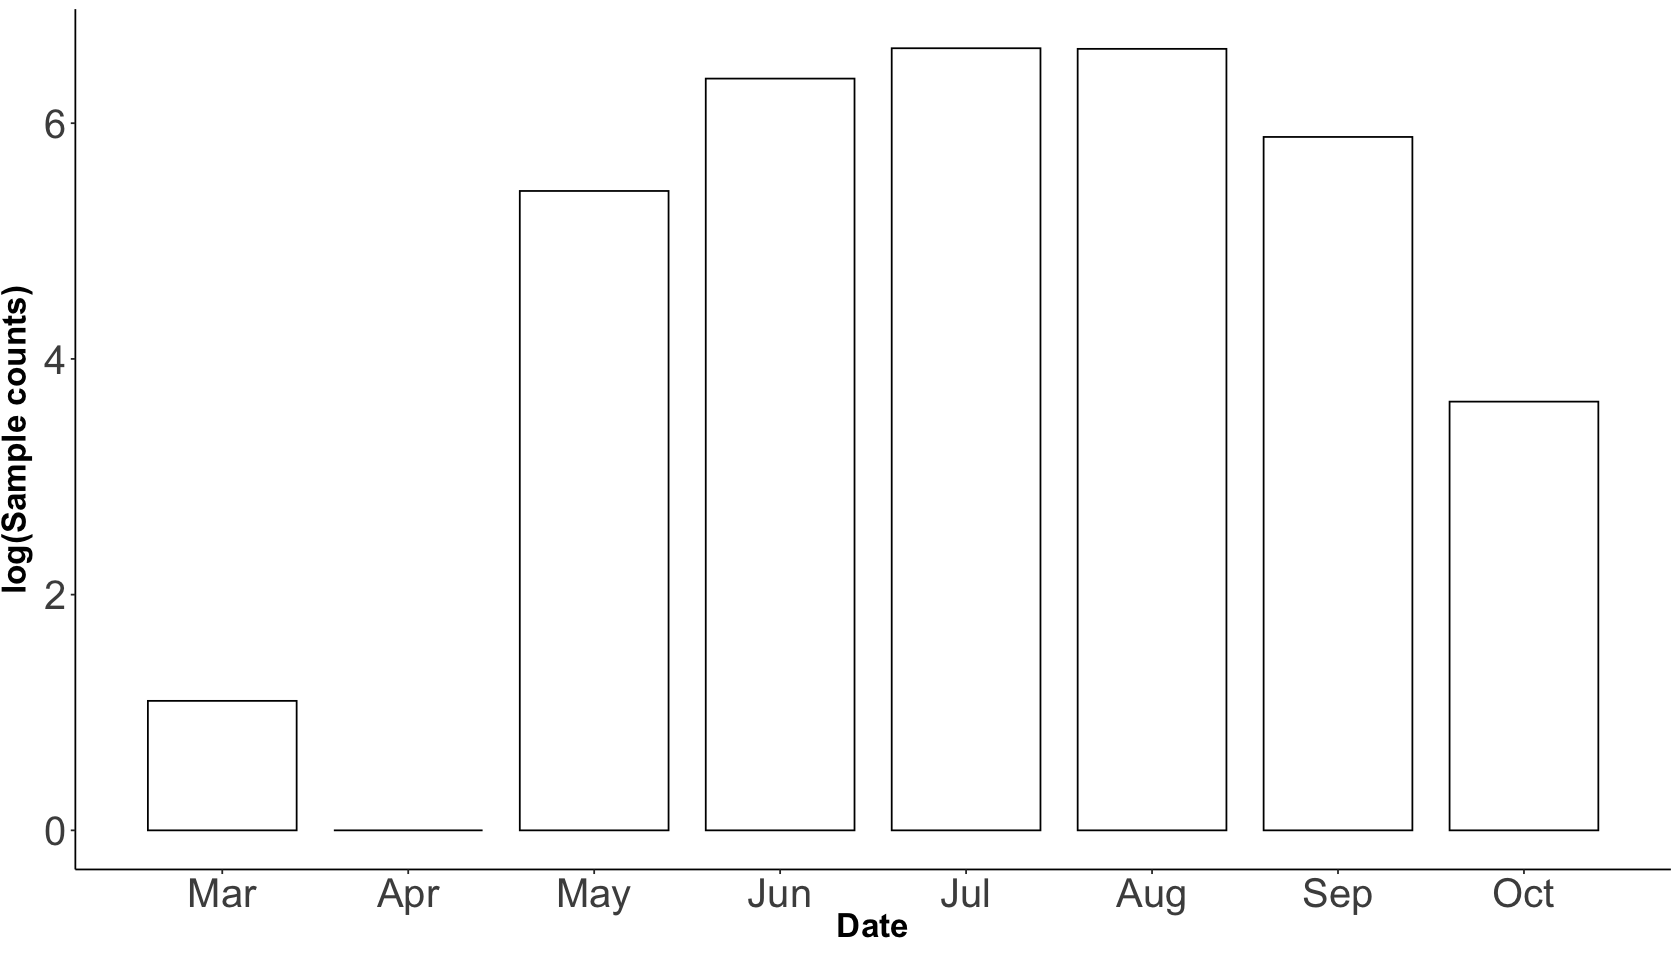

In [553]:
plot_og <- og_month %>% ggplot(aes(y=log(counts), x=month)) + 
         geom_histogram(position="stack", stat="identity", bins=8, width=0.8, fill='white', color='black') + 
         my_theme() + 
         scale_fill_manual(values=color_dic) + 
         ylab('log(Sample counts)') + xlab('Date') +
         scale_x_continuous(labels=function(x) month(x, label=TRUE), breaks = scales::pretty_breaks(n = 8))
                            
plot_og

Warning message in geom_histogram(position = "stack", stat = "identity", bins = 8, :
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(data = meta_month, stat = "identity", fill = "black", :
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


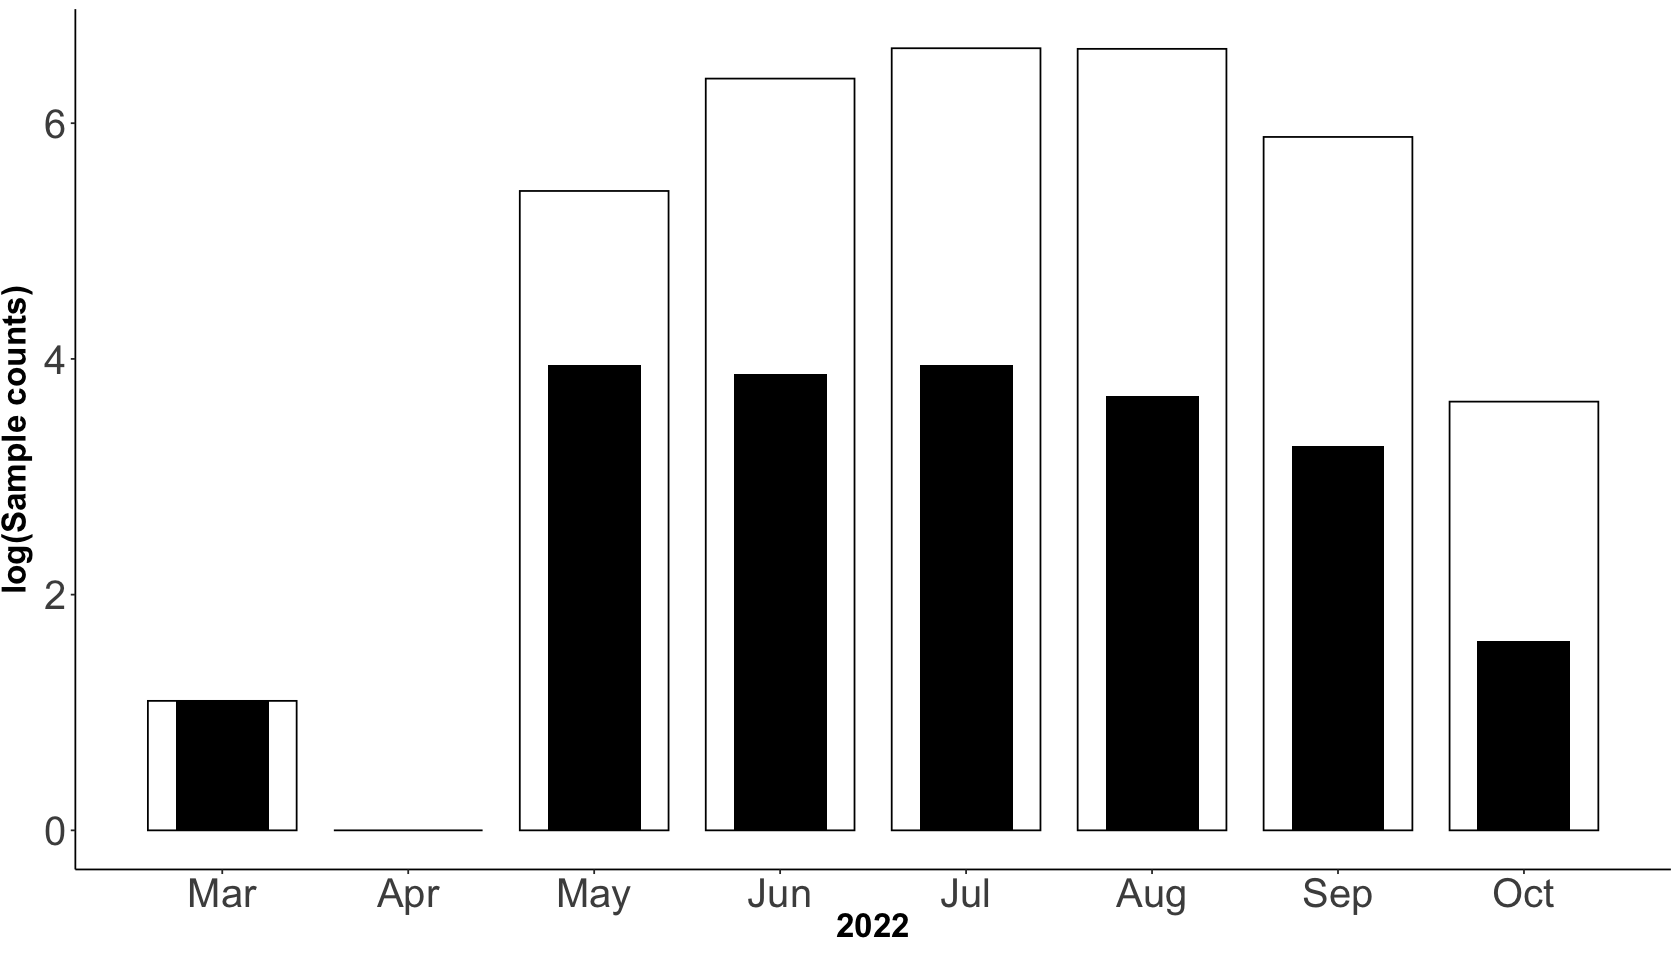

In [608]:
og_month %>% ggplot(aes(y=log(counts), x=month)) + 
         geom_histogram(position="stack", stat="identity", bins=8, width=0.8, fill='white', color='black') + 
         my_theme() + 
         scale_fill_manual(values=color_dic) + 
         ylab('log(Sample counts)') + xlab('2022') +
         scale_x_continuous(labels=function(x) month(x, label=TRUE), breaks = scales::pretty_breaks(n = 8)) + 
         geom_histogram(data=meta_month, stat = 'identity', fill='black',width=0.5)        

#ggsave('relative_counts.png', width = 14, height = 8)

### Sample counts by region 

In [559]:
meta$country <- factor(meta$country,
                       levels= c('Netherlands',
                                 'France',
                                 'United Kingdom',
                                 'Germany',
                                 'Switzerland',
                                 'Belgium',  
                                 'Austria',
                                
                                 'Slovenia',
                                 'Slovakia',
                                 
                                 'Finland',
                                 
                                 'Spain',
                                 'Portugal',
                                 'Italy',
                                 'Colombia',
                                 'Peru',
                                 
                                 'Canada',
                                 'USA'))

og$country <- factor(og$country)

In [602]:
country_month_og <- og %>% group_by(country, month) %>% summarise(counts=n()) %>% mutate(month=month(month, label=T)) 

`summarise()` has grouped output by 'country'. You can override using the `.groups` argument.


In [395]:
color_dic <- c('North America'= '#66c2a5',
               'South America'= '#fc8d62', 
               'Southern Europe'= '#8da0cb',
               'Northern Europe'= '#e78ac3',
               'Central/Eastern Europe'= '#a6d854',
               'Western Europe'= '#ffd92f')

loc <- tibble(country=levels(meta$country),
                   place= c(rep('Western Europe',7),
                              rep('Central/Eastern Europe',2),
                              'Northern Europe',
                              rep('Southern Europe', 3), 
                              rep('South America',2),
                              rep('North America',2)))

meta <- meta %>% left_join(loc, by = 'country')

# A tibble: 28 × 3
# Groups:   month, place [28]
   month place                      n
   <dbl> <chr>                  <int>
 1     3 Western Europe             3
 2     5 Central/Eastern Europe     3
 3     5 North America             10
 4     5 Northern Europe            2
 5     5 Southern Europe           15
 6     5 Western Europe            22
 7     6 Central/Eastern Europe     5
 8     6 North America             10
 9     6 Northern Europe            1
10     6 South America              2
# … with 18 more rows


Warning message in geom_histogram(position = "stack", stat = "identity", bins = 8):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


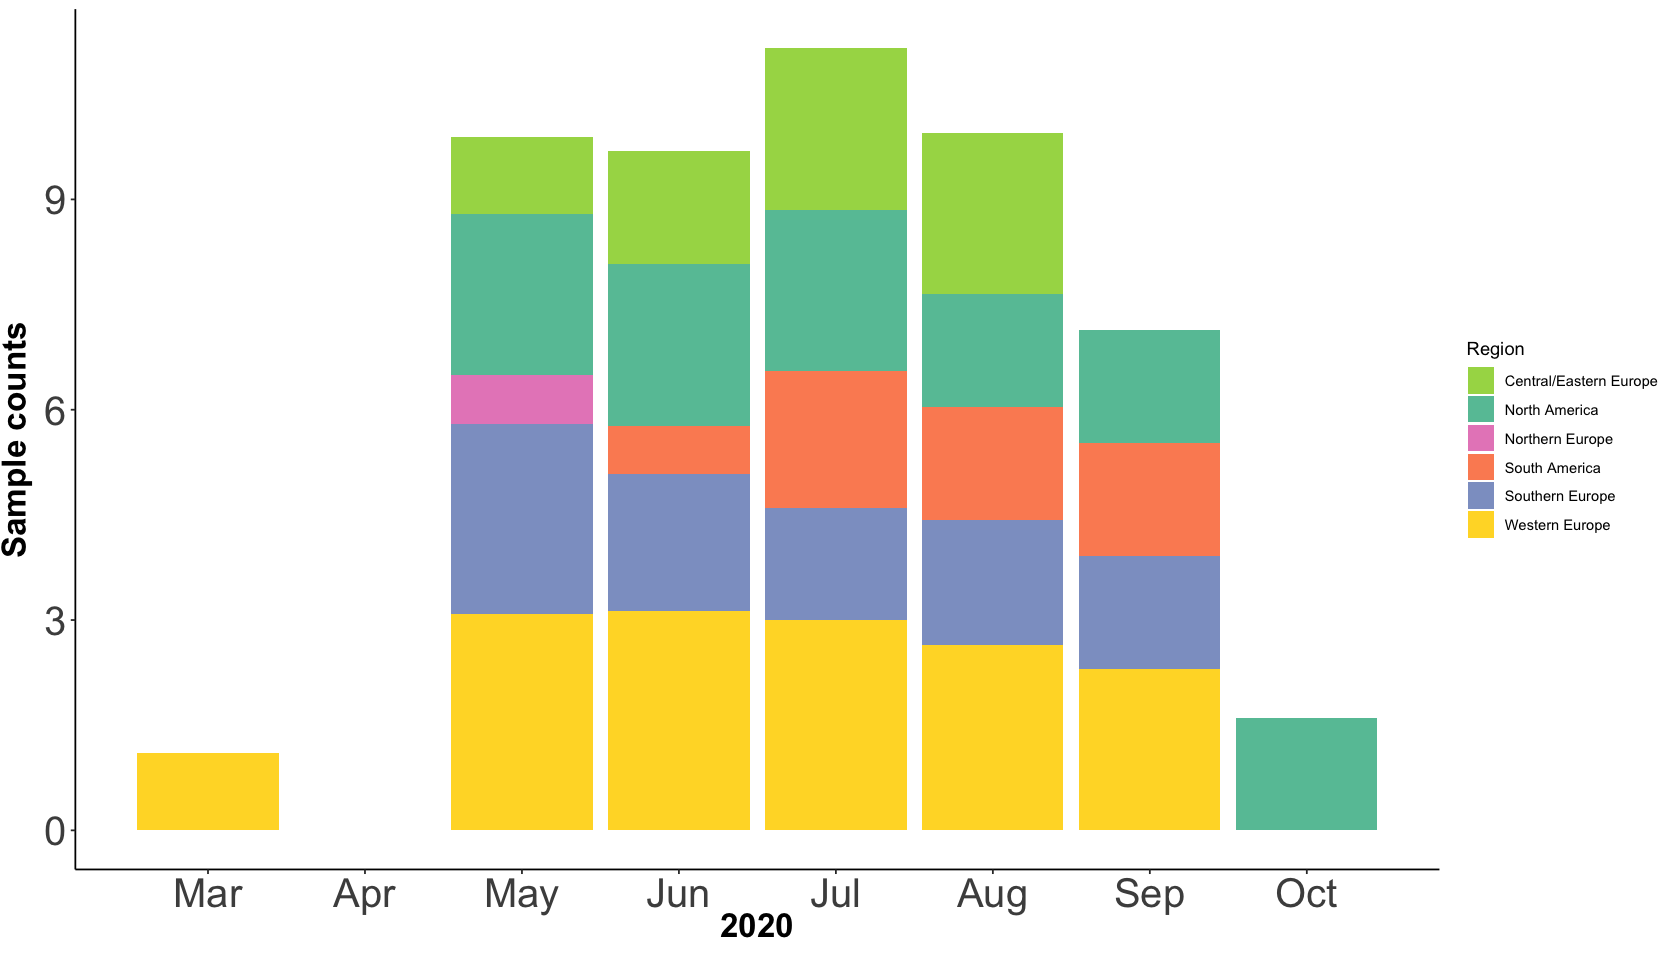

In [533]:
meta_grouped <- meta %>% group_by(month, place) %>% count()

meta_month <- meta %>% group_by(month) %>% count()

plot_meta <- meta %>% group_by(month, place) %>%
         count() %>%
         ggplot(aes(fill=place, y=log(n), x=month)) + 
         geom_histogram(position="stack", stat="identity", bins=8) + 
         my_theme() + 
         scale_fill_manual(values=color_dic) + 
         ylab('Sample counts') + xlab('2020') + guides(fill=guide_legend("Region"))+
         scale_x_continuous(labels=function(x) month(x, label=TRUE), breaks = scales::pretty_breaks(n = 8))
  
plot_meta 

#ggsave('sample_counts_2.png', width = 14, height = 8)